# Here I will use PyTorch to show how backpropagation can be used to modify dynamics on the MullerPotential using a Langevin integrator

The general idea is that we can design a custom loss function based upon the values of feature/collective variables that have already been observed. Propagating the loss back to the x,y postitions will directly give use the additional force that needs to be applied on a particle. 

In stat. mech literature, this technique is called Metadynamics. Basically, the force being applied to a particle is dependent on the accumalated bias as the particular value of feature/collective variable. This comes down to a bunch of chain rules, all of which Pytorch/TensorFlow excel at.  


In [1]:
from msmbuilder.example_datasets import MullerPotential
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', palette='colorblind',context='talk')
import numpy as np
import sys
sys.path.insert(0, "helper_func")
%load_ext autoreload
%autoreload 2


/Users/muneeb/Documents/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/muneeb/Documents/anaconda/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


/Users/muneeb/Documents/anaconda/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/Users/muneeb/Documents/anaconda/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


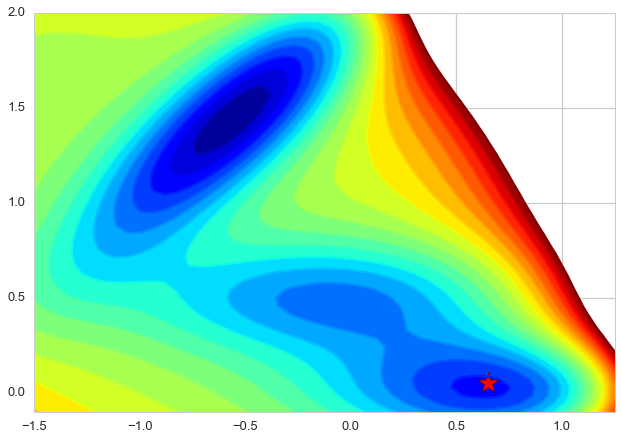

In [2]:
nx, ny = (50, 50)
x = np.linspace(-1.5, 1.25, nx)
y = np.linspace(-.1, 2,ny)
xx, yy = np.meshgrid(x,y)
starting_coor = np.array([.65,0.05])

mp = MullerPotential()
vv = mp.potential(xx,yy)
plt.contour(xx,yy,vv,np.linspace(-150,150,20),cmap='jet')
plt.contourf(xx,yy,vv,np.linspace(-150,150,20),cmap='jet')
plt.xlim([x[0], x[-1]])
plt.ylim([y[0], y[-1]])
plt.scatter(starting_coor[0],starting_coor[1],c='r',s=500,marker='*')

This image above is our sampling space while the red star represents the starting configuration. 

In [3]:
from helper_func.muller_helper import muller_potential,muller_force,propagate

In [4]:
def plot_traj():
    n_frames = 2500
    initial_x = starting_coor
    kT = 15.0
    dt = 0.1
    mGamma = 1000.0
    force = muller_force()
    traj = propagate(n_frames, initial_x, kT, dt, mGamma, force)

    plt.plot(traj[:,0], traj[:,1], 'k', markersize=3)
    return traj

/Users/muneeb/Documents/anaconda/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/Users/muneeb/Documents/anaconda/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


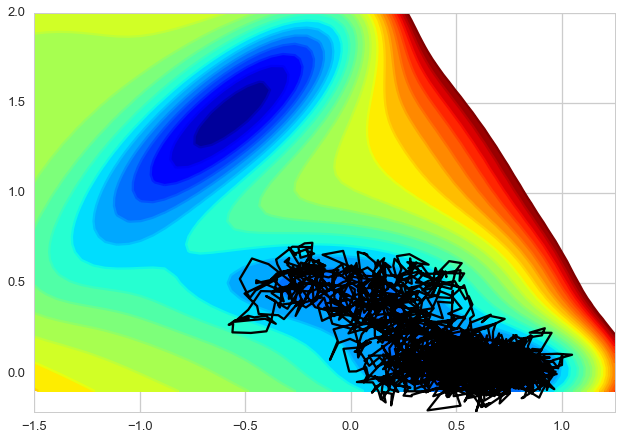

In [5]:
plt.contour(xx,yy,vv,np.linspace(-150,150,20),cmap='jet')
plt.contourf(xx,yy,vv,np.linspace(-150,150,20),cmap='jet')
unbiased_traj = plot_traj()

As it can be seen, even after 2500 steps of dynamics, our random walker has yet to exit its dominant basin.This is a common problem in simulations where we are unable to efficiently sample all major free energy basins during the course of our simulations 

# But we can design an enhanced sampling algorithm using PyTorch

In [6]:
import torch
from torch import autograd
from torch.autograd import Variable

We begin by simply defining our collective variable/ feature using Pytorch

In [7]:
import torch.nn as nn


#This Collective Variable(CV)/Feature will return the x(ind=0) or y(ind=0) position of the position tuple.

class SimpleCV(nn.Module):
    def __init__(self,ind=0):
        super(SimpleCV, self).__init__()
        self.ind = ind
    def forward(self, pos,):
        return pos.narrow(1,self.ind,1)

# Suprisingly the entire Metadynamics algorithm can be ported to PyTorch using about 10 lines of code

Some caveats 

1). It is the regular variant Metadynamics instead of well-tempered Metadynamics

2). We are not using computationally efficent grids which are significantly computationally cheaper
as the simulations progress

3). For now, we are only looking at 1-D variants

In [8]:
# gaussian height and width
height = 2
width = 0.1

def get_pytorch_force(current_frame, hist_tensor,ind, cv_func):
    
    #we want to get the forces on the x/y coordinate of our random walker
    var_pos = autograd.Variable(torch.from_numpy(np.atleast_2d(current_frame)), requires_grad=True)
    cv_val = cv_func(var_pos)
    
    if ind==0:
        hist_tensor = cv_val
    else:
        # add the 
        hist_tensor = torch.cat((cv_val,hist_tensor))

    # The LOSS/BIAS is an exponential kernel to all previously seen values in the history tensor
    bias = torch.sum(height*torch.exp(torch.div(-1 * torch.pow(cv_val - hist_tensor, 2), 2*width**2)))
    # propagate the bias backward to get gradients on x/y position
    bias.backward()
    
    #force is the negative of the gradient
    current_f = -1*np.array(var_pos.grad.data.tolist())
    
    return current_f, hist_tensor

In [9]:
def test_pytorch_force(traj):
    hist= None
    #check both x and y
    for k in range(2):
        s_cv = SimpleCV(k)
        for i,f in enumerate(traj):
            cf, hist = get_pytorch_force(f, hist, i, s_cv)
            expected_f = np.sum(height * (f[k] - traj[:i,k])/width**2 * 
                                np.exp( -1 * (f[k] - traj[:i,k])**2/(2*width**2)))
            assert np.allclose(cf[0][k], expected_f)

#test 50 frames
test_pytorch_force(unbiased_traj[:50])

# Now lets modify the propagator code to use multiple forces

In [10]:
# Most of this code is from https://github.com/rmcgibbo/mullermsm
def meta_propagate(n_frames, initial_x, kT, dt, mGamma, force, cv_func):
    """Propagate high-friction Langevin dynamics on
    the Muller potential
    
    Parameters
    ----------
    n_steps : int
        Number of steps to take
    initial_x : tuple
        x,y coordinates to start at
    kT : float
        boltzmans constant times temperature
    mGamma : float
        mass of the particle ties the friction coefficient
    force : callable
        Callable (e.g. function which takes a length n_dimensions 1D
        array as a single argument and return a length n_dimensions 1D
        array of force in each direction
    cv_func: callable
        Callable CV function 
        
    Reference
    ---------
    .. [1] http://gold.cchem.berkeley.edu/Pubs/DC150.pdf
    """
    
    n_dims = len(initial_x)
    # check to make sure we can really call it
    if not len(force(initial_x)) == n_dims:
        raise ValueError('force not returning the right stuff')
    
   
    # the variance is 2*kT*dt/m*gamma
    random = np.random.normal(scale=np.sqrt((2.0 * kT * dt) / (mGamma)),
        size=(n_frames - 1, 2))
    position = np.zeros((n_frames, 2))
    position[0] = initial_x
    hist_tensor = None
    
    for i in range(n_frames - 1):
        #get the metadynamics force
        meta_force, hist_tensor =  get_pytorch_force(position[i], hist_tensor, i,cv_func)
        normal_force = force(position[i])
        #add it to the normal force 
        total_force = normal_force + meta_force[0]
        if i%100 ==0:
            print(normal_force,meta_force[0],total_force)
        position[i+1] = position[i] + dt / (mGamma) * total_force + random[i]
    
    return position

In [11]:
# And a new plotting function

In [12]:
def plot_traj(cv_func):
    n_frames = 400
    initial_x = starting_coor
    kT = 15.0
    dt = 0.1
    mGamma = 1000.0
    force = muller_force()
    traj = meta_propagate(n_frames, initial_x, kT, dt, mGamma, force, cv_func)

    plt.plot(traj[:,0], traj[:,1], 'k', markersize=3)
    return traj

# Now we can run dynamics using the dynamically upated potential

[-19.33241037 -69.52905882] [-0. -0.] [-19.33241037 -69.52905882]
[ 123.40960307  115.94207969] [-65.31958523  -0.        ] [  58.09001784  115.94207969]
[  69.43347896  118.92388685] [-152.44998606   -0.        ] [ -83.0165071   118.92388685]
[ -59.09839738 -275.09851258] [ 242.11032378   -0.        ] [ 183.01192639 -275.09851258]


/Users/muneeb/Documents/anaconda/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/Users/muneeb/Documents/anaconda/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


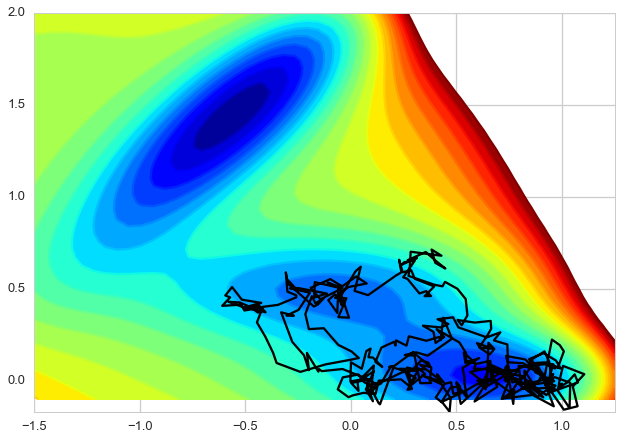

In [13]:
s_cv = SimpleCV(ind=0)
plt.contour(xx,yy,vv,np.linspace(-150,150,20),cmap='jet')
plt.contourf(xx,yy,vv,np.linspace(-150,150,20),cmap='jet')
traj= plot_traj(s_cv)

So using x-axis as the CV is already allowing us to explore the third basin but its not terribly efficient. But the good thing is that we can now define better CVs

# Lets define more complex CV such as y-x

In [14]:
class ComplexCV(nn.Module):
    def __init__(self,):
        super(ComplexCV, self).__init__()
    def forward(self, pos,):
        return pos[:,1]-pos[:,0]

[-19.33241037 -69.52905882] [-0. -0.] [-19.33241037 -69.52905882]
[ -36.30498308 -203.15932199] [-103.4565548  103.4565548] [-139.76153788  -99.70276719]
[  52.62479541 -112.80947733] [-173.85598018  173.85598018] [-121.23118477   61.04650285]
[ 202.85844059  -21.40781383] [-77.01383069  77.01383069] [ 125.8446099    55.60601686]


/Users/muneeb/Documents/anaconda/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/Users/muneeb/Documents/anaconda/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


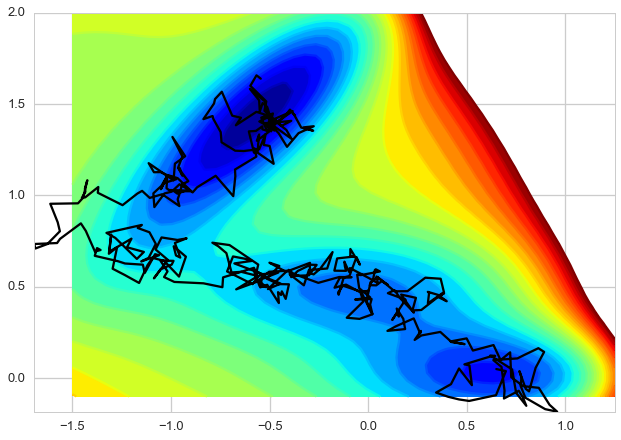

In [15]:
s_cv = ComplexCV()
plt.contour(xx,yy,vv,np.linspace(-150,150,20),cmap='jet')
plt.contourf(xx,yy,vv,np.linspace(-150,150,20),cmap='jet')
traj= plot_traj(s_cv)

This shows you that even seemingly good CVs can cause your simulations to have undesirable behavior of moving into a region of too high energy. 

# Amazingly we can even define Conditional CV that accelerate along the X-coordinate when y < 0.5 and then switch to Y-axis. 

In [16]:
class ConditionalCV(nn.Module):
    def __init__(self,):
        super(ConditionalCV, self).__init__()
    def forward(self, pos,):
        if pos.data[-1,1] < .5:
            return pos[:,0]
        else:
            return pos[:,1]

Note how the PyTorch Force(Middle Column) switches from the x-coordinate to the y-coordinate as simulation time passes

[-19.33241037 -69.52905882] [-0. -0.] [-19.33241037 -69.52905882]
[ 15.00584013  66.351339  ] [ 123.44286081   -0.        ] [ 138.44870094   66.351339  ]
[  69.01195611  164.77904069] [-151.16916417   -0.        ] [ -82.15720806  164.77904069]
[-191.83360686  269.1392877 ] [  -0.         -235.31130354] [-191.83360686   33.82798416]


/Users/muneeb/Documents/anaconda/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/Users/muneeb/Documents/anaconda/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


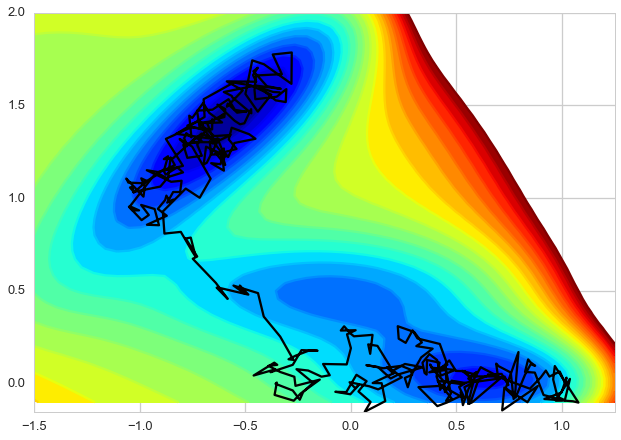

In [17]:
s_cv = ConditionalCV()
plt.contour(xx,yy,vv,np.linspace(-150,150,20),cmap='jet')
plt.contourf(xx,yy,vv,np.linspace(-150,150,20),cmap='jet')
traj= plot_traj(s_cv)

# However, to do this for more complex systems such as proteins, we will turn to Plumed which can interface with optimized and fast molecular dynamics engines. 